# Grad CAM interpretation

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2023-10-29 10:09:04.580605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 10:09:05.294678: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"  # specify which GPU(s) to be used

In [3]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.models import load_model

#model = ResNet50V2(weights = 'imagenet', include_top = True, input_shape=(224,224,3))

n_class= 8#df['order'].unique().shape[0]

model = load_model('model_mobile_checkpoint')

2023-10-29 10:09:06.567487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31136 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


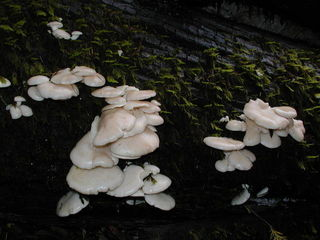

In [4]:
# The local path to our target image
img_path = "../../dataset/order_classification/train/Agaricales/182.jpg"

display(Image(img_path))

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):


    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        inputs = model.inputs, 
        outputs = [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, 6]

    

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

2023-10-29 10:09:09.624680: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904


1/1 [==============================] - 1s 752ms/step
Predictions:  [[9.9999976e-01 2.2927370e-22 5.9431366e-09 1.8301041e-13 3.2747825e-13
  1.0385820e-16 2.0181608e-07 6.3030951e-16]]
Predicted: 0


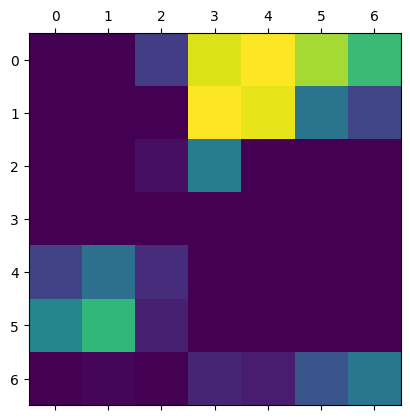

In [6]:
last_conv_layer_name = "conv_pw_13" #"conv5_block3_3_conv"

base_model = model.layers[0]

# Prepare image
preprocess_input = keras.applications.resnet_v2.preprocess_input
decode_predictions = keras.applications.resnet_v2.decode_predictions

img_size = (224,224,3)

img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
#model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
pred_index = np.argmax(preds)
print("Predictions: ", preds)
print("Predicted:", np.argmax(preds))

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [7]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))




/tmp/ipykernel_1109176/1112207413.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


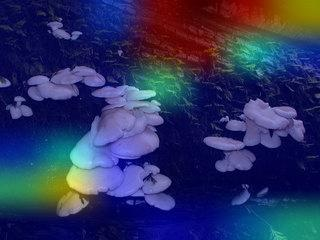

In [10]:
save_and_display_gradcam(img_path, heatmap, alpha=0.8)

In [8]:
def get_augmented_gradcam(img_path, heatmap, alpha=0.4):    
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return superimposed_img

/tmp/ipykernel_1114754/1634637587.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


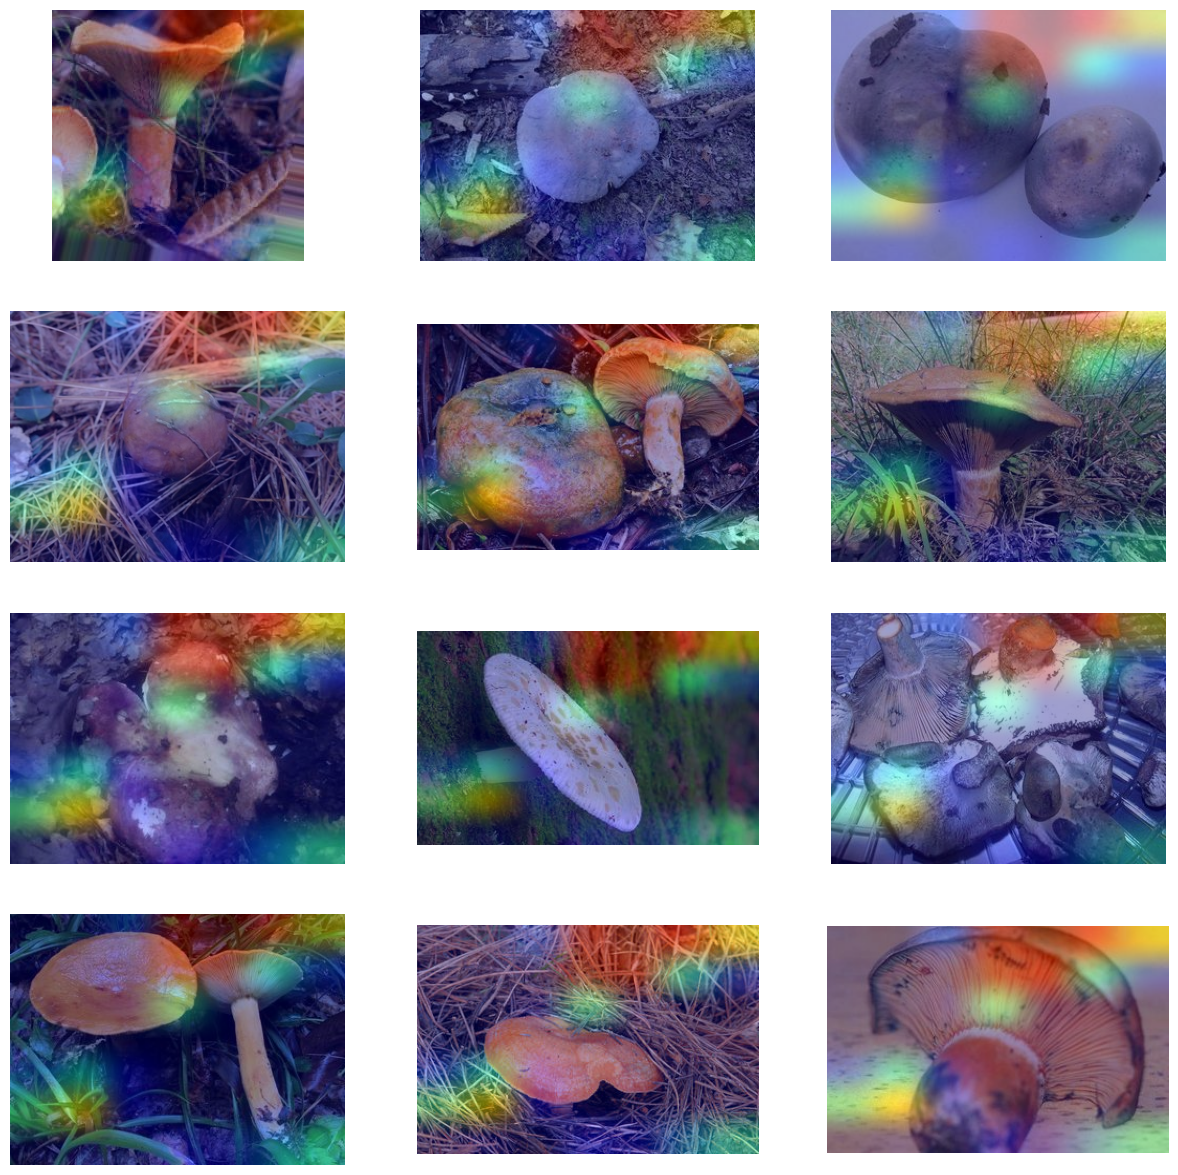

In [14]:
dirpath = '../../dataset/order_classification/test/Russulales'
jpg_files = [f.path for f in os.scandir(dirpath) if f.is_file() and f.name.endswith('.jpg')]
selected_images = random.sample(jpg_files, 12)
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

for i, img_path in enumerate(selected_images):
    img =  get_augmented_gradcam(img_path, heatmap, alpha = 0.6) #mpimg.imread(img_path)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].axis('off')

plt.show()

/tmp/ipykernel_1114754/1634637587.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


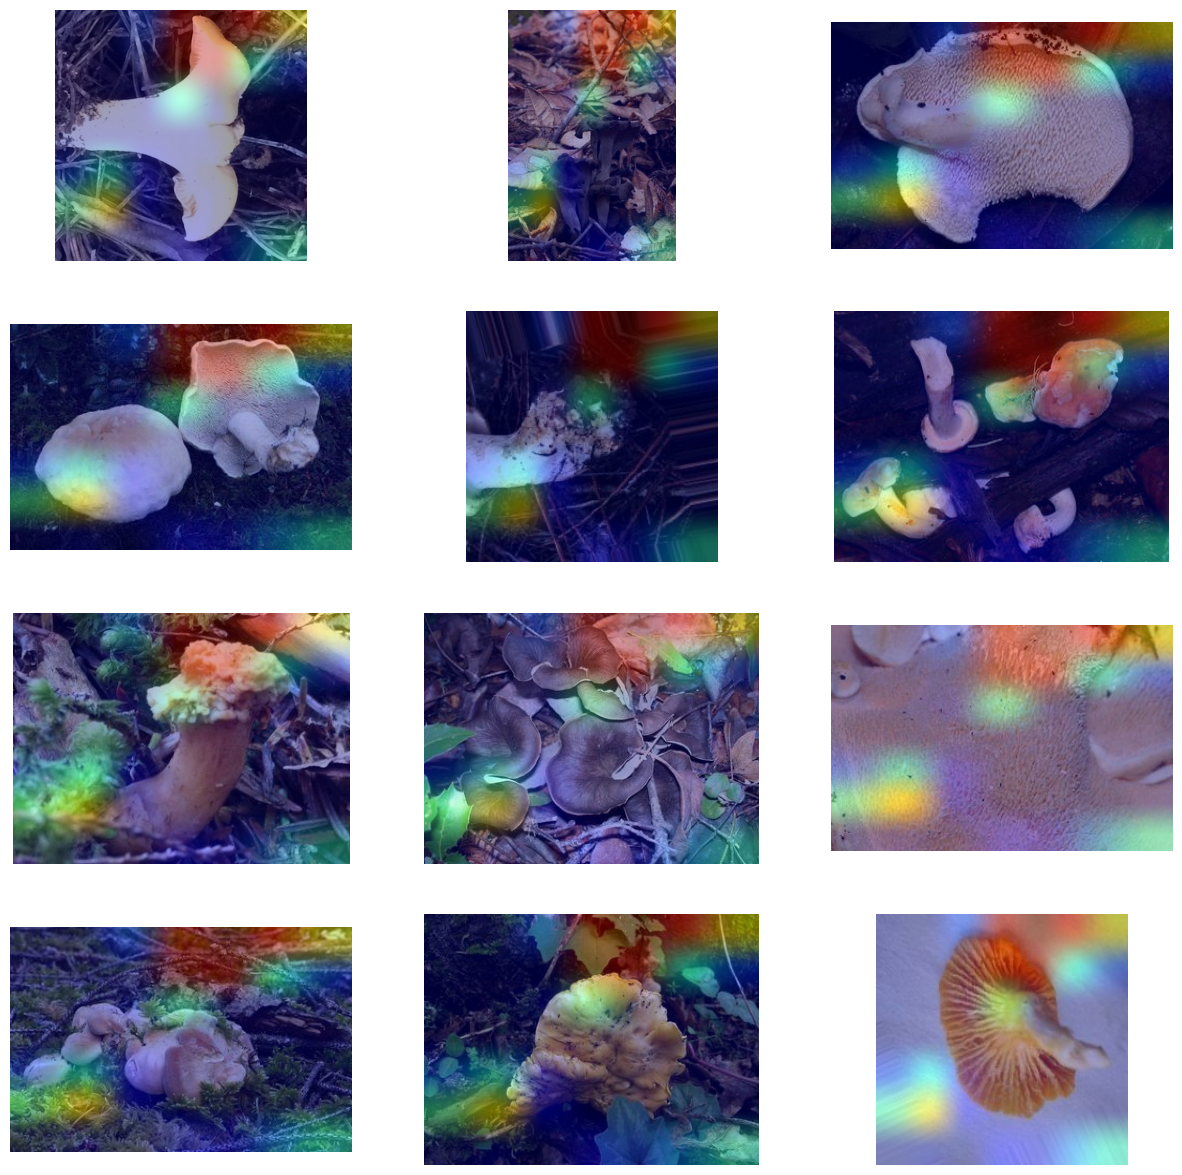

In [12]:
dirpath = '../../dataset/order_classification/test/Cantharellales'
jpg_files = [f.path for f in os.scandir(dirpath) if f.is_file() and f.name.endswith('.jpg')]
selected_images = random.sample(jpg_files, 12)
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

for i, img_path in enumerate(selected_images):
    img =  get_augmented_gradcam(img_path, heatmap, alpha = 0.6) #mpimg.imread(img_path)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].axis('off')

plt.show()

/tmp/ipykernel_1114754/1634637587.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


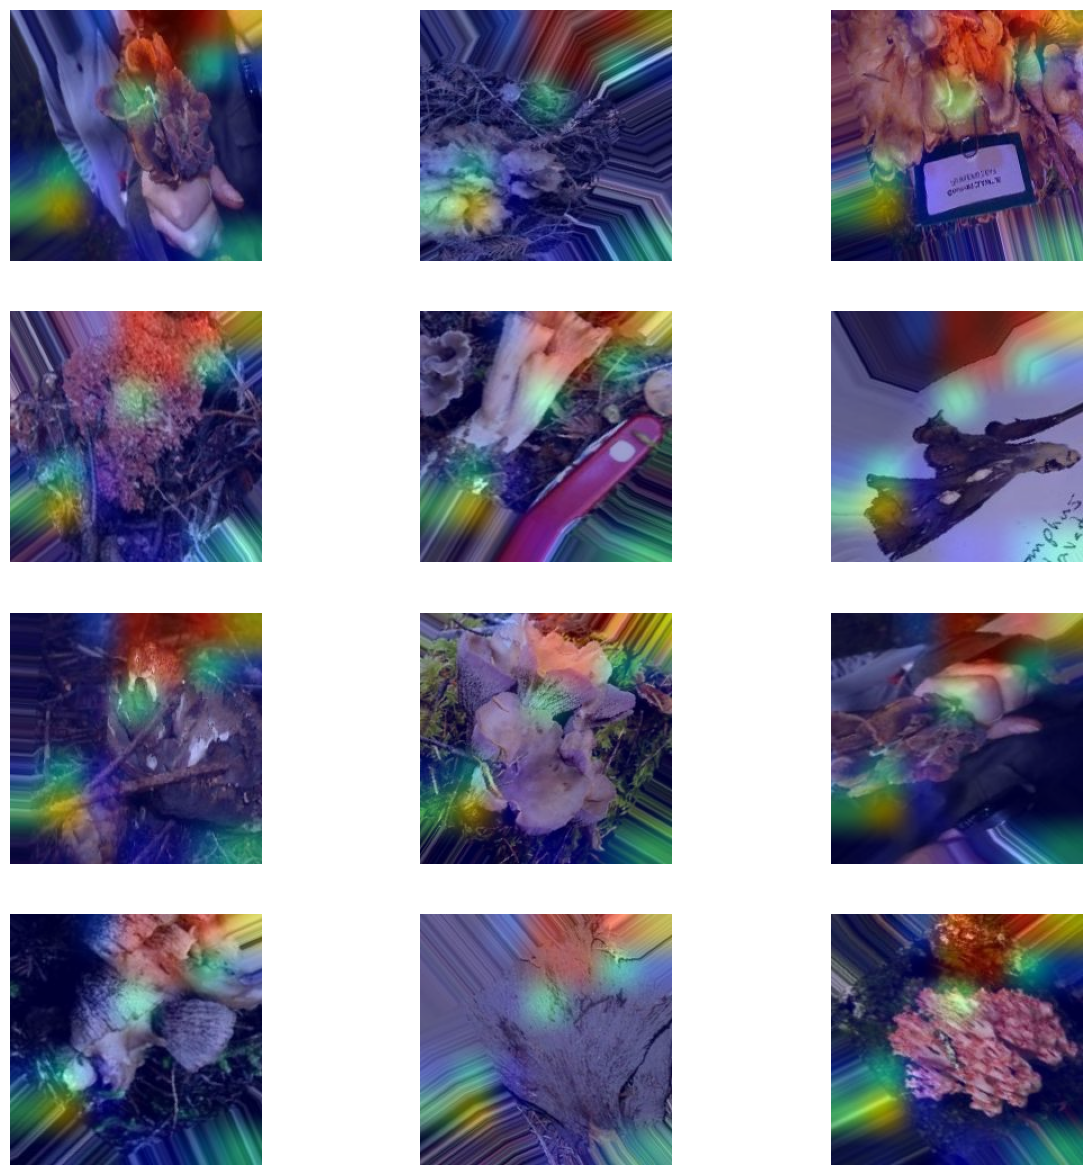

In [15]:
dirpath = '../../dataset/order_classification/test/Gomphales'
jpg_files = [f.path for f in os.scandir(dirpath) if f.is_file() and f.name.endswith('.jpg')]
selected_images = random.sample(jpg_files, 12)
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

for i, img_path in enumerate(selected_images):
    img =  get_augmented_gradcam(img_path, heatmap, alpha = 0.6) #mpimg.imread(img_path)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].axis('off')

plt.show()